>### 🚩 *Create a free WhyLabs account to complete this example!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylabs-free-sign-up?utm_source=github&utm_medium=referral&utm_campaign=langkit)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=github&utm_medium=referral&utm_campaign=LLM_to_WhyLabs) to leverage the power of whylogs and WhyLabs together!*

# Monitoring GPT with LangKit in WhyLabs

Not using OpenAI? LangKit supports all models, both public API and self-hosted. We would love to hop on a quick call to show you how to monitor your LLM. [Grab time here with LangKit engineers](https://calendly.com/whylabs/langkit-feedback).


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/langkit/blob/beta%2Fexamples/langkit/examples/GPT_Intro_to_LangKit.ipynb)

In this example, we'll show how to send your LLM metrics to your monitoring dashboard at WhyLabs Platform.
We will:

- Install LangKit
- Define environment variables with the appropriate Credentials and IDs
- Connect LangKit to WhyLabs
- Generating telemetry on your prompts and responses and send to WhyLabs
- Explore LangKit telemetry in WhyLabs
- Send the profile to your Project at WhyLabs

## Installing LangKit

First, let's install a beta build of __langkit__. Note: you may need to restart the kernel to use updated packages.

In [1]:
%pip install https://whylabs-public.s3.us-west-2.amazonaws.com/langkit/beta/langkit-0.0.1b0-py3-none-any.whl

To test the installation worked run the following "Hello, World!" example (note the first time you import these langkit modules it will need to download models):

In [6]:
import whylogs as why
from whylogs.experimental.core.metrics.udf_metric import generate_udf_schema
from whylogs.core.schema import DeclarativeSchema
from langkit.sentiment import *
from langkit.textstat import *
from langkit.regexes import *
from langkit.themes import *

langkit_schema = DeclarativeSchema(generate_udf_schema())
profile_view = why.log({"prompt": "Hello,", "response": "World!"}, schema=langkit_schema).view()

This verifies that the installation and initialization of models worked, and now this text_schema can be used to profile you LLM. If you are curious what kinds of metrics are gathered you can see a dictionary of the metrics gathered on this Hello, World! example by running something like this:
```python
    profile_view.get_column("prompt").get_metric("udf").to_summary_dict()
```

## ✔️ Setting the Environment Variables

In order to send our profile to WhyLabs, let's first set up an account. You can skip this if you already have an account and a model set up.

We will need three pieces of information:

- API tokens for the LLM and WhyLabs
- Organization ID for WhyLabs
- Dataset ID for WhyLabs


Go to [https://whylabs.ai/free](https://whylabs.ai/whylabs-free-sign-up?utm_source=github&utm_medium=referral&utm_campaign=langkit) and grab a free account. You can follow along with the examples if you wish, but if you’re interested in only following this demonstration, you can go ahead and skip the quick start instructions.

After that, you’ll be prompted to create an API token. Once you create it, copy and store it locally. The second important information here is your org ID. Take note of it as well. After you get your API Token and Org ID, you can go to https://hub.whylabsapp.com/models to see your projects dashboard. You can create a new project and take note of it's ID (if it's a model project it will look like `model-xxxx`).

*Note: If using OpenAI chat completion, We recommend testing this integration with a paid account using gpt-3.5-turbo: https://platform.openai.com/docs/guides/chat*

We'll now set the credentials as environment variables. The WhyLabs Writer will check for the existence of these variables in order to send the profiles to your dashboard. In a production setting these would already be set as environment variables, but 

In [ ]:
import getpass
import os

whylabs_api_key = os.environ.get("WHYLABS_API_KEY")
org_id = os.environ.get("WHYLABS_DEFAULT_ORG_ID")
dataset_id = os.environ.get("WHYLABS_DEFAULT_DATASET_ID")
if whylabs_api_key is None:
    print("Enter your WhyLabs API key")
    os.environ["WHYLABS_API_KEY"] = getpass.getpass()
    print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])
else:
    print("Whylabs API Key already set with ID: ", os.environ["WHYLABS_API_KEY"][0:10])
if org_id is None:
    print("Enter your WhyLabs Org ID")
    os.environ["WHYLABS_DEFAULT_ORG_ID"] = input()
    org_id = os.environ.get("WHYLABS_DEFAULT_ORG_ID")
else:
    print(f"WhyLabs Org ID is already set in env var to: {org_id}")
if dataset_id is None:
    # set your datased_id (or model_id) here - should be something like "model-xxxx"
    print("Enter your WhyLabs Dataset ID")
    os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input()
    dataset_id = os.environ.get("WHYLABS_DEFAULT_DATASET_ID")
else:
    print(f"WhyLabs Dataset ID is already set in env var to: {dataset_id}")

### Example Basic OpenAI gpt-3.5-turbo integration:

```python
import os
from typing import Optional
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

class ChatLog:
    def __init__(self, prompt: str, response: str, errors: Optional[str] = None):
        self.prompt = prompt
        self.response = response
        self.errors = errors

    def to_dict(self):
        return {
            "prompt": self.prompt,
            "response": self.response,
            "errors" : self.errors
        }

# this is just for demonstration purposes
def send_prompt(prompt: str) -> ChatLog:
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{
                "role": "system",
                "content": "The following is a conversation with an AI assistant."
            }, {
                "role": "user",
                "content": prompt
            }],
            temperature=0.9,
            max_tokens=100,
            frequency_penalty=0,
            presence_penalty=0.6
        )
    except Exception as e:
        return ChatLog(prompt, "", f"{e}")

    result = ''
    for choice in response.choices:
        result += choice.message.content

    return ChatLog(prompt, result)
```

If you have an integration like the above or another LLM, you can log the `ChatLog`'s dictionary using a LangKit schema and a `whylogs` rolling logger.

## ✍️ Connect LangKit to WhyLabs

### Production integrations should take a look at our [docs](https://docs.whylabs.ai/docs/usecases-streaming/) and use something like the code sample below

```python
from whylogs.experimental.core.metrics.udf_metric import generate_udf_schema
from whylogs.core.schema import DeclarativeSchema
import whylogs as why
from langkit.sentiment import *
from langkit.textstat import *
from langkit.regexes import *
from langkit.themes import *

langkit_schema = DeclarativeSchema(generate_udf_schema())

# initialize a persistent whylogs logger as a telemetry agent, that will periodically
# write the metrics to a configured location.
telemetry_agent = why.logger(
    schema=langkit_schema,
    mode="rolling",
    interval=300,
    when="S",
)

# Adds a whylabs writer (it will write the aggregate statistics and metrics to WhyLabs)
# you can also use 'local' for local file store, or s3, and various other writers.
telemetry_agent.append_writer("whylabs")
```

## 📊 Generating Telemetry on your prompts and responses

For demonstration, let's use some more archived response/prompts data from Hugging Face, or you can interact with GPT to see how it works in real time if you already have an OpenAI api key.

In [22]:
from datasets import load_dataset

from whylogs.api.writer.whylabs import WhyLabsWriter
import whylogs as why


archived_chats = load_dataset('alespalla/chatbot_instruction_prompts', split="test", streaming=True)
archive_iterator = iter(archived_chats)
prompt_response = next(archive_iterator)
profile = why.log(prompt_response, schema=langkit_schema).profile()
profile.track({"prompt":"Wow this is amazing!! I can believe you were able to do that.", "response": "As an AI language model"})

writer = WhyLabsWriter()
writer.write(profile)

(True, 'log-qRU2oflNXN0fvWap')

The above cell read an archived prompt/reponse pair profiled it and sent these privacy preserving metrics to WhyLabs.

*Note: you need to have defined a WhyLabs API Key, and other environment variables above in order to write profiles to WhyLabs.*

Next lets profile a few batches of data and send their profiles to WhyLabs to simulate an LLM application integrated with LangKit that has been running for over a week. From this we can visualize how the profile's metrics change over time. From the WhyLabs platform you can setup monitors on your LLM application using these LangKit extracted metrics.

In [ ]:
from datetime import datetime, timedelta, timezone

# For demo purposes only, for production use case see the above telemetry_agent example
print(f"Log prompt/responses for the past 7 days.")
batch_size = 10
current_date = datetime.now(timezone.utc)
for day in range(1, 7):
  prompt_response = next(archive_iterator)
  profile = why.log(prompt_response, schema=langkit_schema).profile()
  archived_prompt_responses = []
  dataset_date = current_date - timedelta(days=day)
  print(f"Downloading archived batch for {dataset_date}")
  for _ in range(10):
    record = next(archive_iterator)
    archived_prompt_responses.append(record)

  for record in archived_prompt_responses:
    profile.track(record)
    print(".", end="", flush=True)

  profile.set_dataset_timestamp(dataset_date)
  writer.write(profile)
  print()
print("Done. Go see your metrics on the WhyLabs dashboard!")

## 🔍 Understanding LangKit telemetry in WhyLabs

Now, check your dashboard to verify everything went ok. At the __Profile__ tab, you should see something like this:

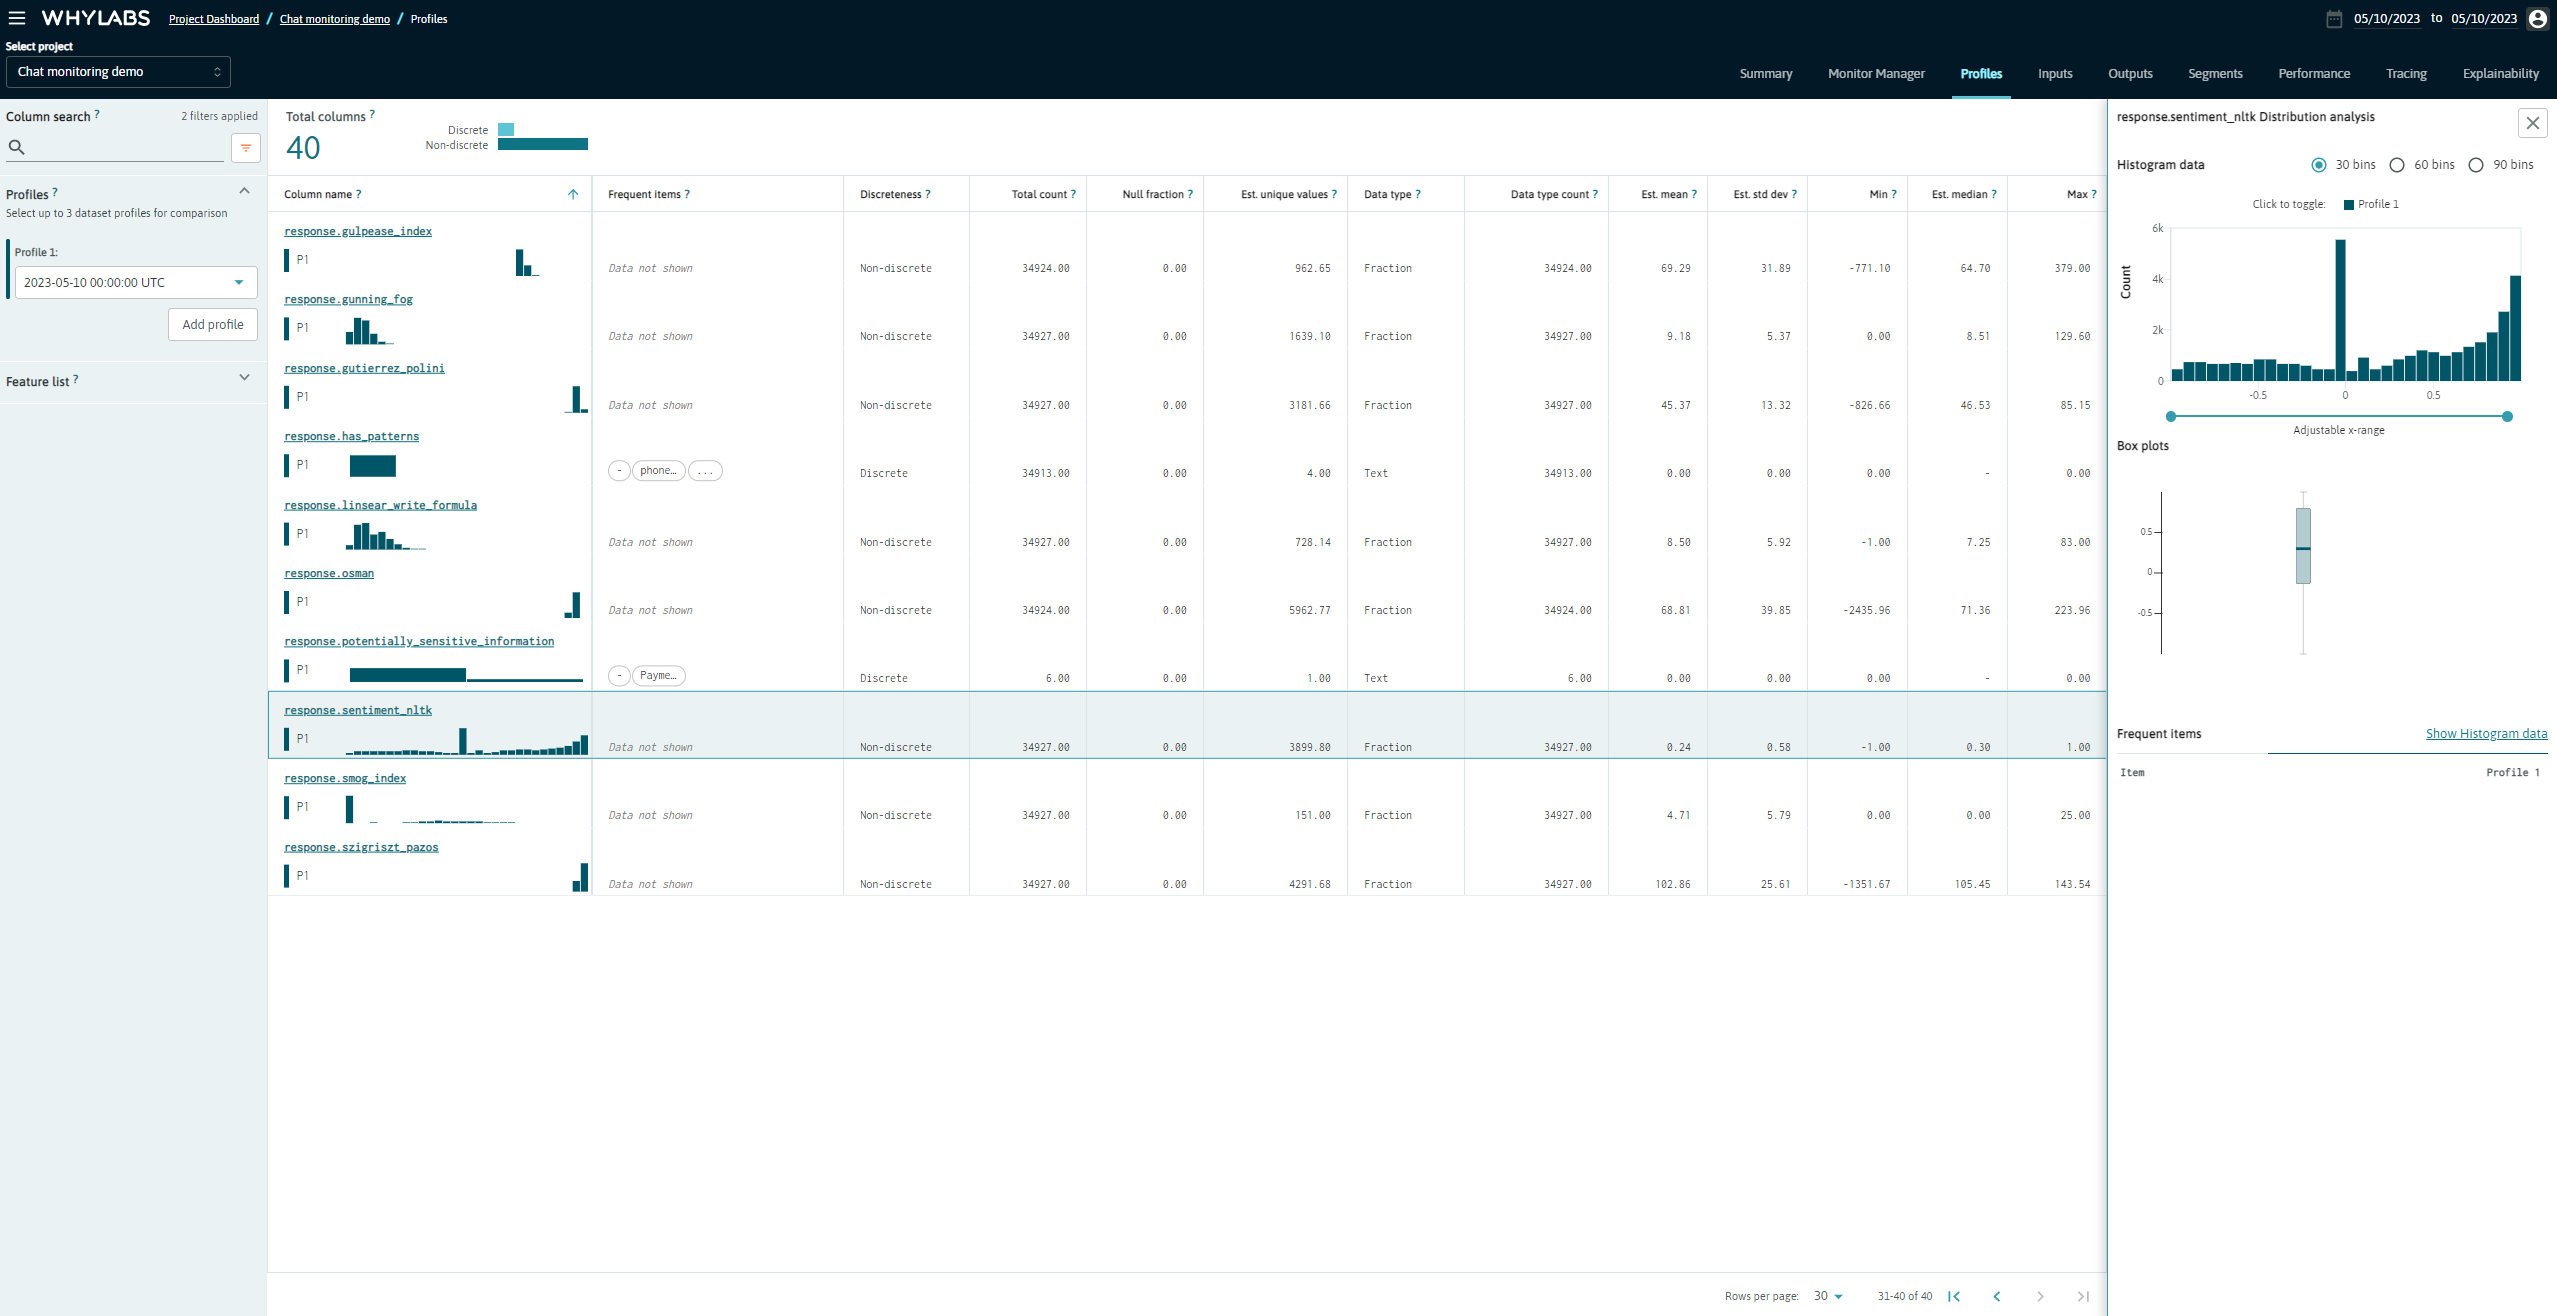

## ⚠️ Monitor your LLM Application

This should give you a quick way to look at your extracted metrics on the prompts and responses, and these can be [monitored](https://docs.whylabs.ai/docs/monitor-manager#preset-monitors) over time! Try out the numerical drift preset monitor and preview results to see something like this:

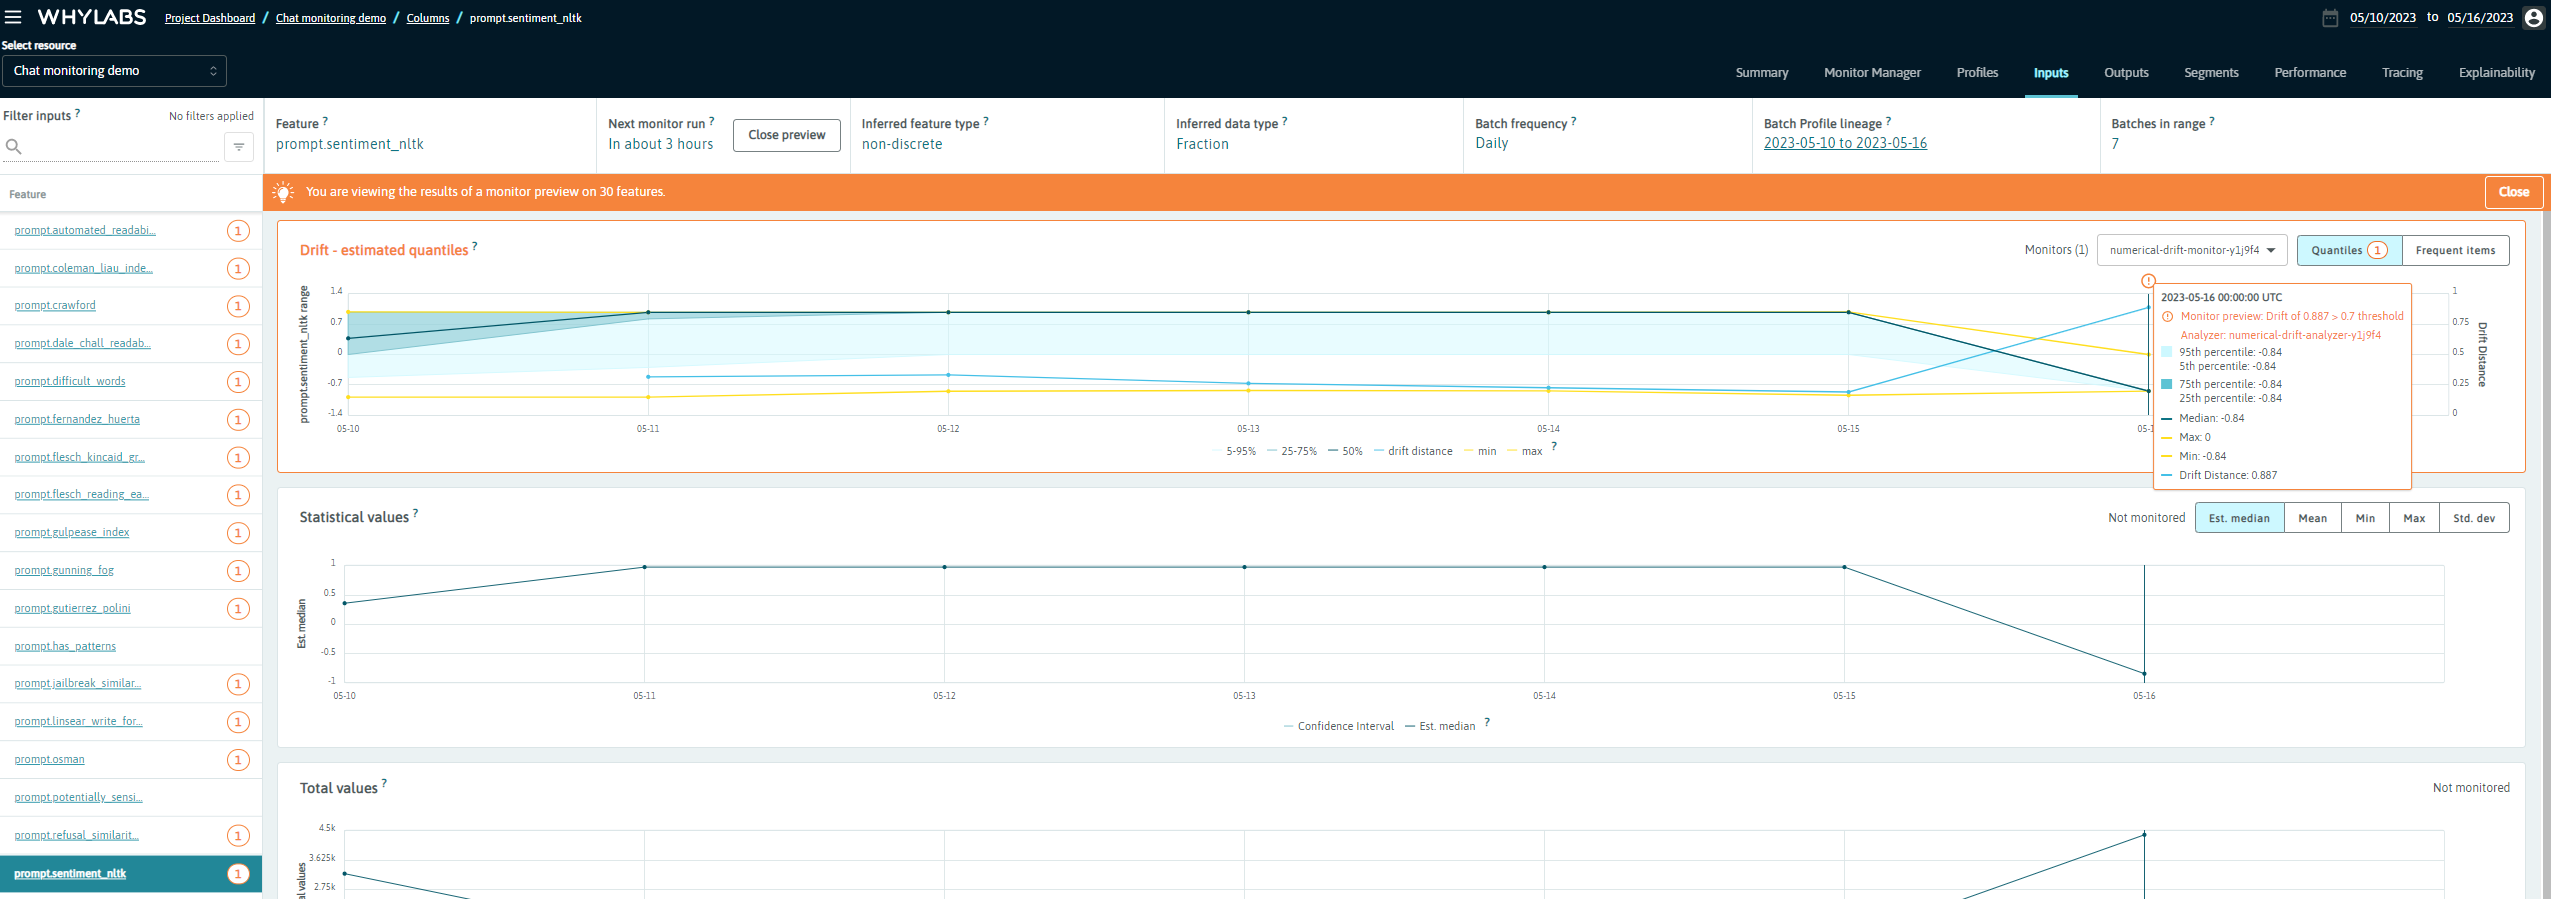